In [1]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, losses, models

import tensorflow_datasets as tfds

In [2]:
PATH_ROOT = 'HorsesAndHumans/'

LATENT_DIM = 256

IMG_WEIGHT = IMG_HEIGHT = 32
CHAHHELS = 3

EPOCHS = 40

In [3]:
data_dir = pathlib.Path(PATH_ROOT)

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WEIGHT),
    shuffle=True
)

Found 1283 files belonging to 2 classes.
Using 1027 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WEIGHT),
    shuffle=True
)

Found 1283 files belonging to 2 classes.
Using 256 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['horses', 'humans']


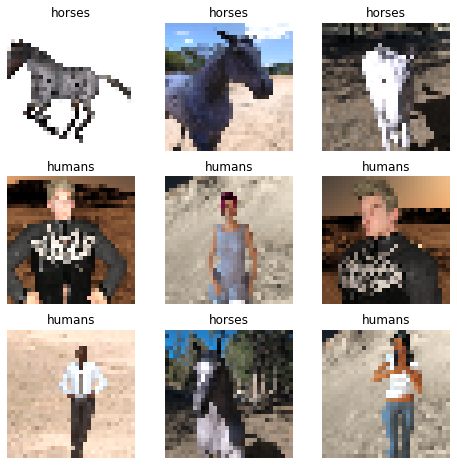

In [7]:
plt.figure(figsize=(8, 8))
for img, lbls in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[lbls[i]])
        plt.axis('off')

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=-1)
val_ds = val_ds.cache().prefetch(buffer_size=-1)

In [9]:
for img, lbl in tfds.as_numpy(train_ds):
    train_img, train_lbl = img, lbl
    
for img, lbl in tfds.as_numpy(val_ds):
    val_img, val_lbl = img, lbl

In [10]:
train_img = train_img.astype('float32') / 255.
val_img = val_img.astype('float32') / 255.

In [11]:
class Autoencoder(models.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim*2, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(IMG_HEIGHT*IMG_WEIGHT*CHAHHELS, activation='sigmoid'),
            layers.Reshape((IMG_HEIGHT, IMG_WEIGHT, CHAHHELS)),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
autoencoder = Autoencoder(LATENT_DIM)

autoencoder.compile(optimizer='nadam', loss=losses.MeanSquaredError(), metrics=['accuracy'])

In [13]:
history = autoencoder.fit(train_img, train_img,
                epochs=EPOCHS,
                shuffle=True,
                validation_data=(val_img, val_img),
                validation_batch_size=1,
                batch_size=1,
                verbose=0, 
                workers=1)

In [14]:
def view_examples(true, decode, labels):
    
    n = 10
    plt.figure(figsize=(20, 4))

    for i in range(n):

        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(true[i])
        plt.axis('off')

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decode[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')

    plt.show()

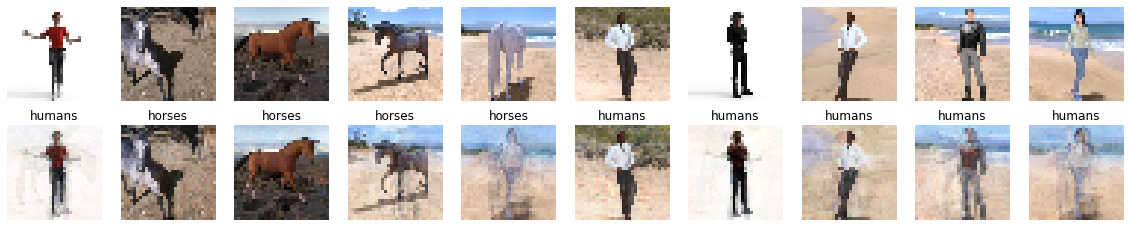

In [15]:
train_encoded = autoencoder.encoder(train_img).numpy()
train_decoded = autoencoder.decoder(train_encoded).numpy()

view_examples(train_img, train_decoded, train_lbl)

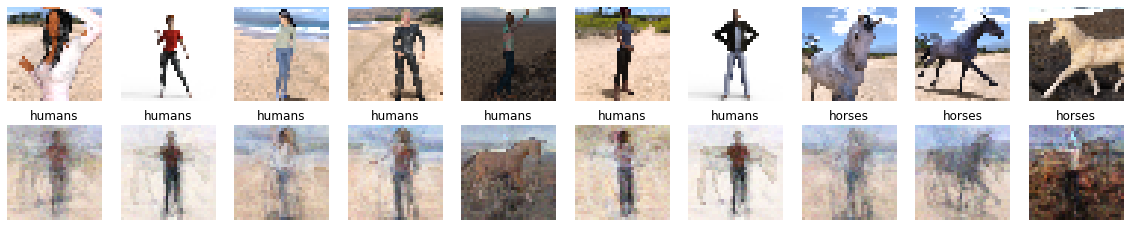

In [16]:
val_encoded = autoencoder.encoder(val_img).numpy()
val_decoded = autoencoder.decoder(val_encoded).numpy()

view_examples(val_img, val_decoded, val_lbl)

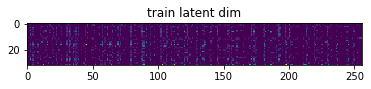

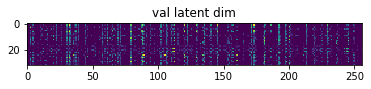

In [17]:
plt.imshow(train_encoded)
plt.title('train latent dim')
plt.show()

plt.imshow(val_encoded)
plt.title('val latent dim')
plt.show()

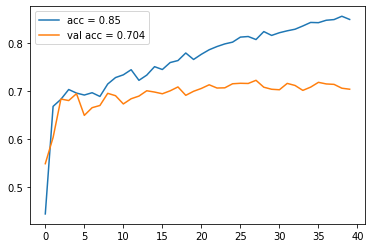

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(history.history['accuracy'], label=f'acc = {round(acc[-1], 3)}')
plt.plot(history.history['val_accuracy'], label=f'val acc = {round(val_acc[-1], 3)}')
plt.legend()